--- Minimum Variance Portfolio ---
  AAPL: 0.2969
  AMZN: 0.0000
 GOOGL: 0.1977
  MSFT: 0.5054
  TSLA: 0.0000
  NVDA: 0.0000
  META: 0.0000
Expected Return : 0.1808
Volatility      : 0.2550
Sharpe Ratio    : 0.7088

--- Maximum Sharpe Portfolio ---
  AAPL: 0.0512
  AMZN: 0.0000
 GOOGL: 0.0000
  MSFT: 0.0000
  TSLA: 0.0384
  NVDA: 0.9103
  META: 0.0000
Expected Return : 0.5259
Volatility      : 0.5005
Sharpe Ratio    : 1.0507

--- Maximum Return Portfolio ---
  AAPL: 0.0000
  AMZN: 0.0000
 GOOGL: 0.0000
  MSFT: 0.0000
  TSLA: 0.0000
  NVDA: 1.0000
  META: 0.0000
Expected Return : 0.5525
Volatility      : 0.5267
Sharpe Ratio    : 1.0490



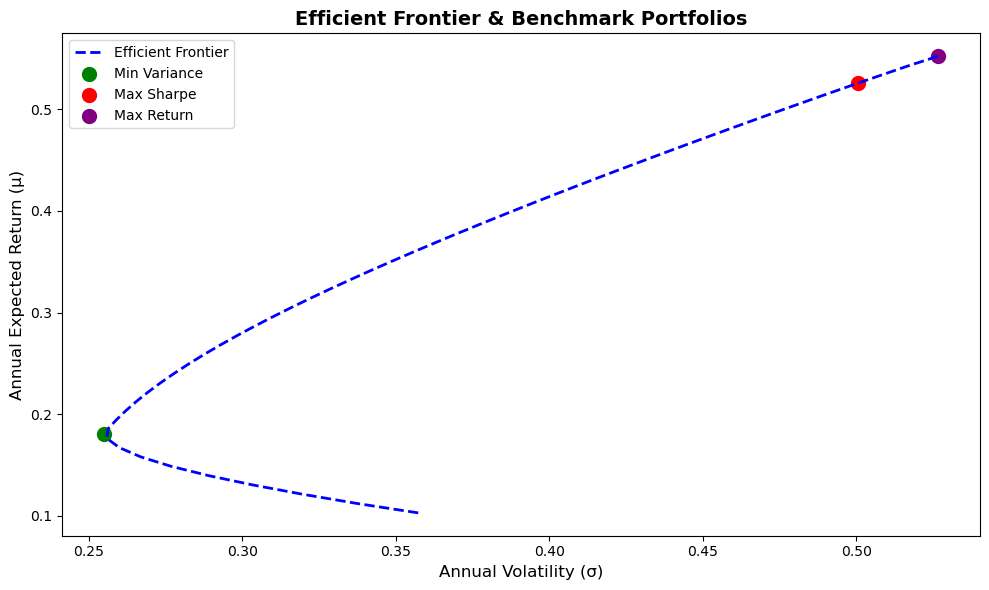

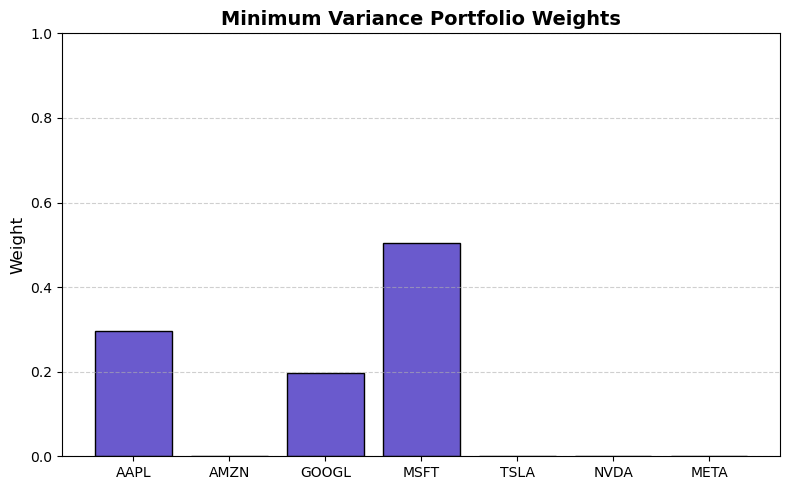

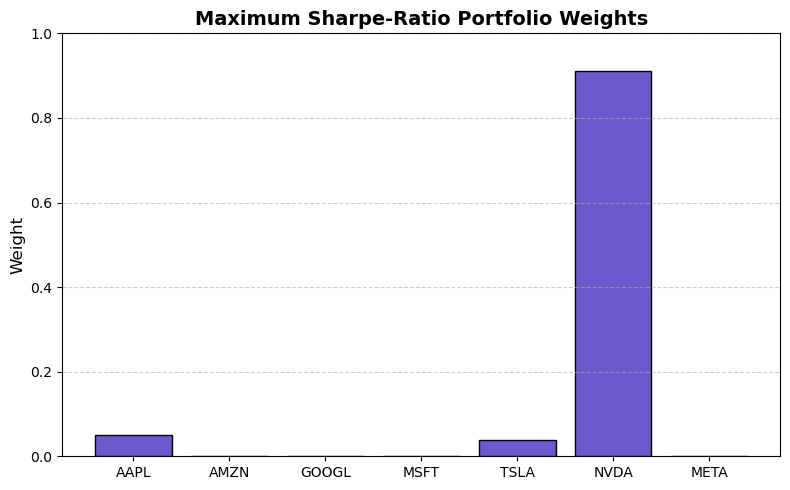

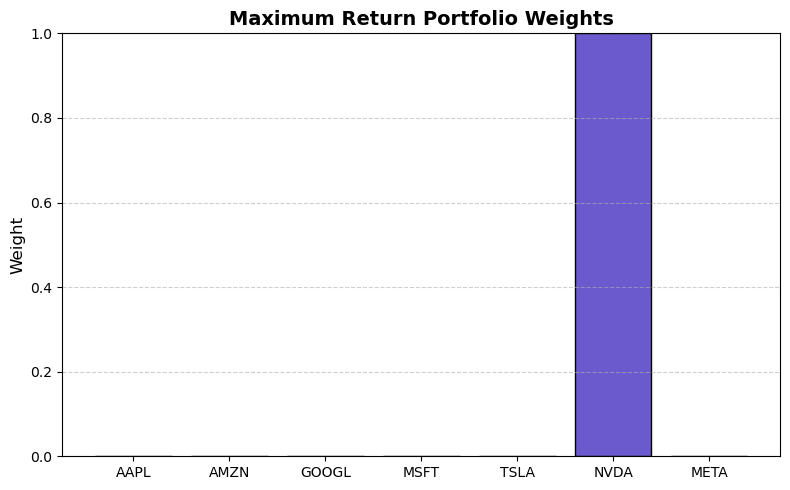

In [3]:
# mpt_portfolio_analysis.py

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------------------
# 1. LOAD & CLEAN HISTORICAL PRICE DATA
# -------------------------------------
# Assumes data/Historical_data.csv has columns: Date, AAPL, AMZN, GOOGL, MSFT, TSLA
df = pd.read_csv(
    "Historical_data.csv",
    parse_dates=["Date"],
    index_col="Date",
    dtype=str
)
# Remove any "$" or "," characters and convert to float
df.replace({r"[\$,]": ""}, regex=True, inplace=True)
df = df.astype("float64")

# -------------------------------------
# 2. ENSURE CHRONOLOGICAL ORDER
# -------------------------------------
df = df.sort_index(ascending=True)

# -------------------------------------
# 3. CALCULATE LOG RETURNS
# -------------------------------------
log_returns = np.log(df / df.shift(1)).dropna()

# -------------------------------------
# 4. ANNUALIZE MEAN & COVARIANCE
# -------------------------------------
trading_days = 252
mean_returns = log_returns.mean() * trading_days           # (n_assets,)
cov_matrix = log_returns.cov() * trading_days              # (n_assets × n_assets)
asset_names = mean_returns.index.tolist()
n_assets = len(asset_names)

# -------------------------------------
# 5. PORTFOLIO PERFORMANCE FUNCTION
# -------------------------------------
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    """
    Returns: (annual_return, annual_volatility, Sharpe_ratio)
    """
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = (port_return - risk_free_rate) / port_vol if port_vol != 0 else 0.0
    return port_return, port_vol, sharpe

# -------------------------------------
# 6. CONSTRAINTS & BOUNDS (LONG-ONLY, FULLY INVESTED)
# -------------------------------------
bounds = tuple((0.0, 1.0) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)

# -------------------------------------
# 7. MINIMUM VARIANCE PORTFOLIO
# -------------------------------------
def minimize_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

init_guess = np.ones(n_assets) / n_assets
minvar_result = minimize(
    minimize_volatility,
    init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
minvar_weights = minvar_result.x
minvar_ret, minvar_vol, minvar_sharpe = portfolio_performance(
    minvar_weights, mean_returns.values, cov_matrix.values
)

# -------------------------------------
# 8. MAXIMUM SHARPE-RATIO (TANGENCY) PORTFOLIO
# -------------------------------------
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return - (port_return - risk_free_rate) / port_vol

maxsharpe_result = minimize(
    negative_sharpe,
    init_guess,
    args=(mean_returns.values, cov_matrix.values, 0.0),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
maxsharpe_weights = maxsharpe_result.x
maxsharpe_ret, maxsharpe_vol, maxsharpe_sharpe = portfolio_performance(
    maxsharpe_weights, mean_returns.values, cov_matrix.values
)

# -------------------------------------
# 9. MAXIMUM RETURN PORTFOLIO
# -------------------------------------
def negative_return(weights, mean_returns):
    return -np.dot(weights, mean_returns)

maxret_result = minimize(
    negative_return,
    init_guess,
    args=(mean_returns.values,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
maxret_weights = maxret_result.x
maxret_ret, maxret_vol, maxret_sharpe = portfolio_performance(
    maxret_weights, mean_returns.values, cov_matrix.values
)

# -------------------------------------
# 10. EFFICIENT FRONTIER GENERATION
# -------------------------------------
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_vols = []
efficient_weights = []

for tr in target_returns:
    # Constraint: port_return == tr
    constraints_eff = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'eq', 'fun': lambda w, ret=tr: np.dot(w, mean_returns.values) - ret}
    )
    result = minimize(
        minimize_volatility,
        init_guess,
        args=(cov_matrix.values,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_eff
    )
    if result.success:
        efficient_vols.append(result.fun)
        efficient_weights.append(result.x)
    else:
        efficient_vols.append(np.nan)
        efficient_weights.append(None)

# Convert lists to arrays for plotting
efficient_vols = np.array(efficient_vols)
target_returns = np.array(target_returns)

# -------------------------------------
# 11. PRINT NUMERICAL RESULTS
# -------------------------------------
def print_portfolio(name, weights, ret, vol, sharpe):
    print(f"--- {name} Portfolio ---")
    for asset, w in zip(asset_names, weights):
        print(f"{asset:>6}: {w:.4f}")
    print(f"Expected Return : {ret:.4f}")
    print(f"Volatility      : {vol:.4f}")
    print(f"Sharpe Ratio    : {sharpe:.4f}\n")

print_portfolio("Minimum Variance", minvar_weights, minvar_ret, minvar_vol, minvar_sharpe)
print_portfolio("Maximum Sharpe", maxsharpe_weights, maxsharpe_ret, maxsharpe_vol, maxsharpe_sharpe)
print_portfolio("Maximum Return", maxret_weights, maxret_ret, maxret_vol, maxret_sharpe)

# -------------------------------------
# 12. VISUALIZATIONS
# -------------------------------------

# 12.1 Efficient Frontier with Benchmarks
plt.figure(figsize=(10, 6))
plt.plot(efficient_vols, target_returns, 'b--', linewidth=2, label='Efficient Frontier')
plt.scatter(minvar_vol, minvar_ret, marker='o', color='green', s=100, label='Min Variance')
plt.scatter(maxsharpe_vol, maxsharpe_ret, marker='o', color='red', s=100, label='Max Sharpe')
plt.scatter(maxret_vol, maxret_ret, marker='o', color='purple', s=100, label='Max Return')
plt.title("Efficient Frontier & Benchmark Portfolios", fontsize=14, fontweight='bold')
plt.xlabel("Annual Volatility (σ)", fontsize=12)
plt.ylabel("Annual Expected Return (μ)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# 12.2 Bar Chart: Portfolio Weights
def plot_weights(weights, title):
    plt.figure(figsize=(8, 5))
    plt.bar(asset_names, weights, color='slateblue', edgecolor='black')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel("Weight", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_weights(minvar_weights, "Minimum Variance Portfolio Weights")
plot_weights(maxsharpe_weights, "Maximum Sharpe-Ratio Portfolio Weights")
plot_weights(maxret_weights, "Maximum Return Portfolio Weights")
